<a href="https://colab.research.google.com/github/rim-yu/SGU_ANT6207_Assignment/blob/master/imagedata_feature_extraction_dimensionRedunction_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이미지 준비하기

### 방법
1. 이미지 사이즈 128
2. sample_files = full path

In [0]:
%matplotlib inline
import os
import os.path
from pathlib import Path
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from pathlib import Path
import glob
import argparse
import cv2
import json

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
cd /content/drive/"My Drive"/data 
# 프로그램이 data 폴더에서 돌게끔. 

/content/drive/My Drive/data


In [0]:
# 새로 만듦. 
dirnames = sorted(glob.glob("./01_*")) # 폴더명들이 리스트로 만들어짐. 
filenames = []
sample_imgs = []

for i in range(len(dirnames)):
  file_path = sorted(glob.glob(dirnames[i] + "/01_*")) # 각 폴더별로 파일 경로. 
  filenames.append(file_path) # 폴더 별로 파일들이 담긴 리스트가 있음. 
  full_path = sum(filenames, []) # 한 리스트에 모든 파일 경로들을 넣음. 
  for j in range(len(full_path)):
    a = plt.imread(full_path[j])
    sample_imgs.append

In [122]:
print(sample_imgs[10].shape)

(461, 615, 3)


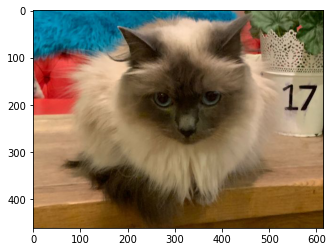

In [71]:
plt.imshow(sample_imgs[10])

# CNN으로 특징 추출하기

### 방법
1. 미리 학습된 imageNET weight 로딩하기.(vgg16모델)

In [72]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from keras import layers
from keras import optimizers


#1. 미리 학습된 imageNET 로딩하기.(vgg16모델)
model = keras.applications.VGG16(weights='imagenet', include_top=True)
model.summary()

Using TensorFlow backend.


553467904/553467096 [==============================] - 40s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [73]:
#2. 마지막 레이어를 feature extractor로 규정해서 이미지들을 4096개의 벡터화 하기.
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
#sample_imgs 모두 뽑아서 feature에 넣기

features =[]
for i, img in enumerate(sample_imgs):
    img_x = image.load_img(full_path[i], target_size=model.input_shape[1:3])
    img_x = image.img_to_array(img_x)
    img_x = np.expand_dims(img_x, axis=0)
    img_x = preprocess_input(img_x)
    feat = feat_extractor.predict(img_x)[0]
    features.append(feat)

In [0]:
print(features[0].shape)

(4096,)


In [0]:
#3. 벡터화된 이미지들을 PCA로 차원축소하여 특징 추출하기. (n_component는 하이퍼 파라미터이기 때문에 정의해줘야함)
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=10, whiten=False)
# pca = PCA(n_components=50, whiten=False)
# pca = PCA(n_components=300, whiten=False)
pca.fit(features)
pca_features = pca.transform(features)

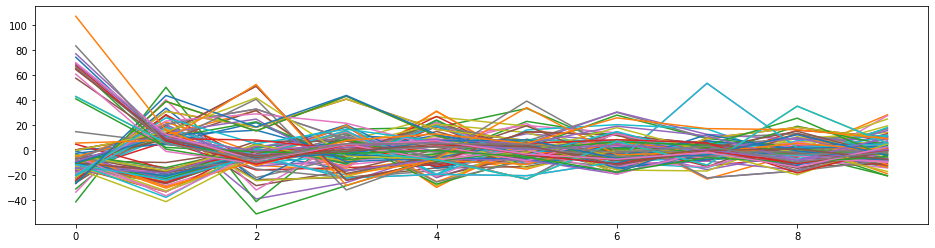

In [93]:
plt.figure(figsize=(16,4))

for index, f in enumerate(pca_features):
    plt.plot(f)

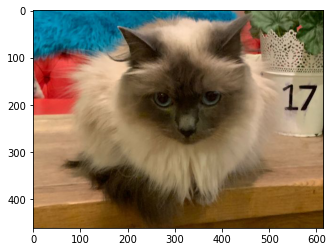

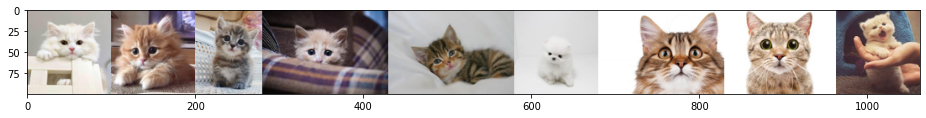

In [94]:
#3-2. 이미지들 사이에서 가장 유사한 이미지 찾아내기
import random

# grab a random query image
# query_image_idx = int(len(sample_imgs) * random.random())
# query_image_idx = 38
query_image_idx = 10

# let's display the image
img_t = sample_imgs[query_image_idx]
plt.imshow(img_t)

from scipy.spatial import distance
similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:10]

thumbs = []
for idx in idx_closest:
    img = sample_imgs[idx]
    img = Image.fromarray(img, 'RGB')
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)
    
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
plt.figure(figsize = (16,12))
plt.imshow(concat_image)

In [98]:
import pickle
f = open("features_200511.txt", "wb")
pickle.dump([test_path, sample_imgs, pca_features, pca], f)
f.close # data 폴더에 저장됨. 지금 프로그램이 어디서 돌고 있냐에 따라서 저장 위치가 결정되는 듯. 

<function BufferedWriter.close>

# 차원축소 후 클러스터 보기.

### 방법
1. 저장한 feature 파일 로딩하기.
2. t-sne를 이용하여 차원 축소 후 2D로 보기.
3. u-map을 이용하여 차원 축소 후 2D로 보기.

In [0]:
%matplotlib inline
import json
from matplotlib.pyplot import imshow
from PIL import Image
from sklearn.manifold import TSNE

In [0]:
#1. 저장한 feature 파일 로딩하기.
files, images, pca_features, pca = pickle.load(open("features_200511.txt", 'rb'))

num_images_to_plot = len(sample_imgs)

if len(images) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

In [101]:
#2.t-sne를 이용하여 차원 축소 후 2D로 보기.
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=120, perplexity=30, angle=0.5, verbose=2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 98 samples in 0.000s...
[t-SNE] Computed neighbors for 98 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 98 / 98
[t-SNE] Mean sigma: 32.896360
[t-SNE] Computed conditional probabilities in 0.016s
[t-SNE] Iteration 50: error = 53.2049179, gradient norm = 0.7099432 (50 iterations in 0.023s)
[t-SNE] Iteration 100: error = 53.1823883, gradient norm = 0.6275063 (50 iterations in 0.025s)
[t-SNE] Iteration 150: error = 52.8618164, gradient norm = 0.6470506 (50 iterations in 0.022s)
[t-SNE] Iteration 200: error = 51.6387482, gradient norm = 0.6873747 (50 iterations in 0.022s)
[t-SNE] Iteration 250: error = 52.9029236, gradient norm = 0.6577398 (50 iterations in 0.022s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.902924
[t-SNE] Iteration 300: error = 0.2457387, gradient norm = 0.0118466 (50 iterations in 0.021s)
[t-SNE] Iteration 350: error = 0.1409605, gradient norm = 0.0022608 (50 

In [0]:
#2-1. t-sne 데이터 노멀라이징 하기 (0 ~ 1)
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

98it [00:00, 629.05it/s]


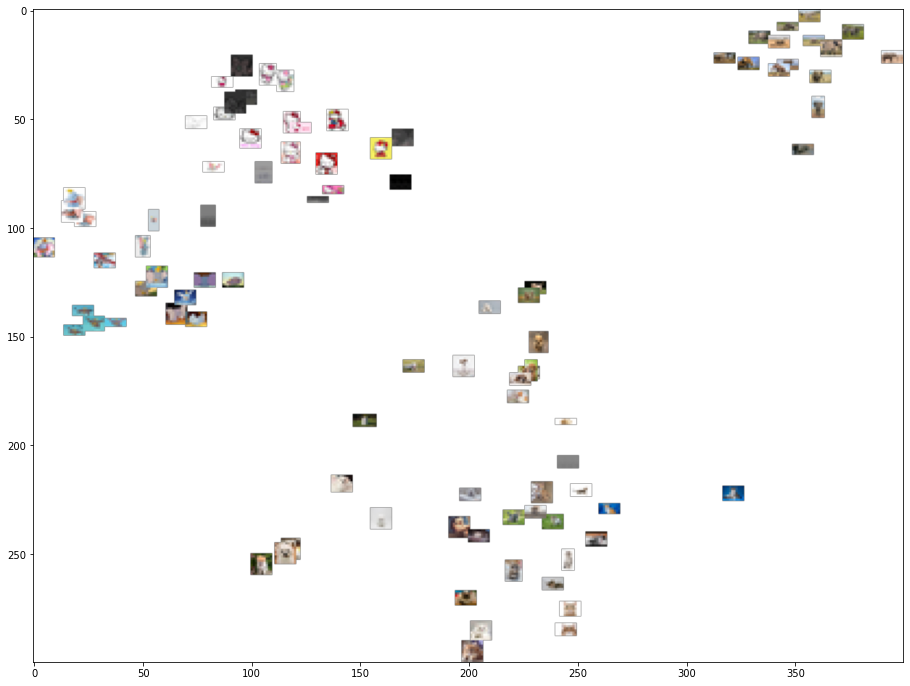

In [103]:
##2-2. t-sne plotting 하기
from tqdm import tqdm
from matplotlib.pyplot import imshow
import matplotlib.pyplot

width = 400
height = 300
max_dim = 10

full_image = Image.new('RGBA', (width, height))

for img, x, y in tqdm(zip(images, tx, ty)):
    tile = Image.fromarray(img, 'RGB')
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

820it [00:00, 281704.42it/s]


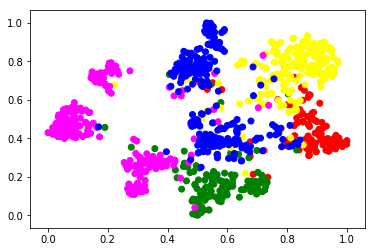

In [0]:
# 지현 씨가 돌린 코드 

import matplotlib.pyplot as plt

# Function to map the colors as a list from the input list of x variabls
cols = []
def pltcolor(l):
    if l=='01':
        col='red'
    elif l=='02':
        col='green'
    elif l=='03':
        col='yellow'
    elif l=='04':
        col='magenta'
    else:
        col='blue'
    return col
# Create the colors list using the function above


for file, img, x, y in tqdm(zip(files,images, tx, ty)):
    category = file.split("_")
#     color= ['red' if g == category[0] else 'green' for g in group]
    col = pltcolor(category[0])
#     print(file+':'+category[0]+':'+col)
    cols.append(col)

plt.scatter(tx,ty, color=cols)
plt.show()

98it [00:00, 184158.51it/s]


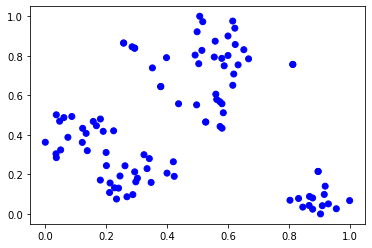

In [104]:
import matplotlib.pyplot as plt

# Function to map the colors as a list from the input list of x variabls
cols = []
def pltcolor(l):
    if l=='01':
        col='red'
    elif l=='02':
        col='green'
    elif l=='03':
        col='yellow'
    elif l=='04':
        col='magenta'
    else:
        col='blue'
    return col
# Create the colors list using the function above


for file, img, x, y in tqdm(zip(files,images, tx, ty)):
    category = file.split("_")
#     color= ['red' if g == category[0] else 'green' for g in group]
    col = pltcolor(category[0])
#     print(file+':'+category[0]+':'+col)
    cols.append(col)

plt.scatter(tx,ty, color=cols)
plt.show()

820it [00:00, 233348.89it/s]


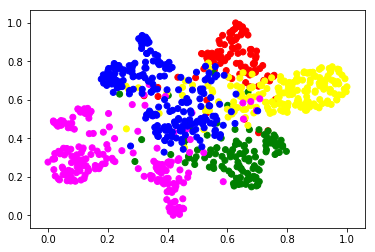

820it [00:00, 3167.05it/s]


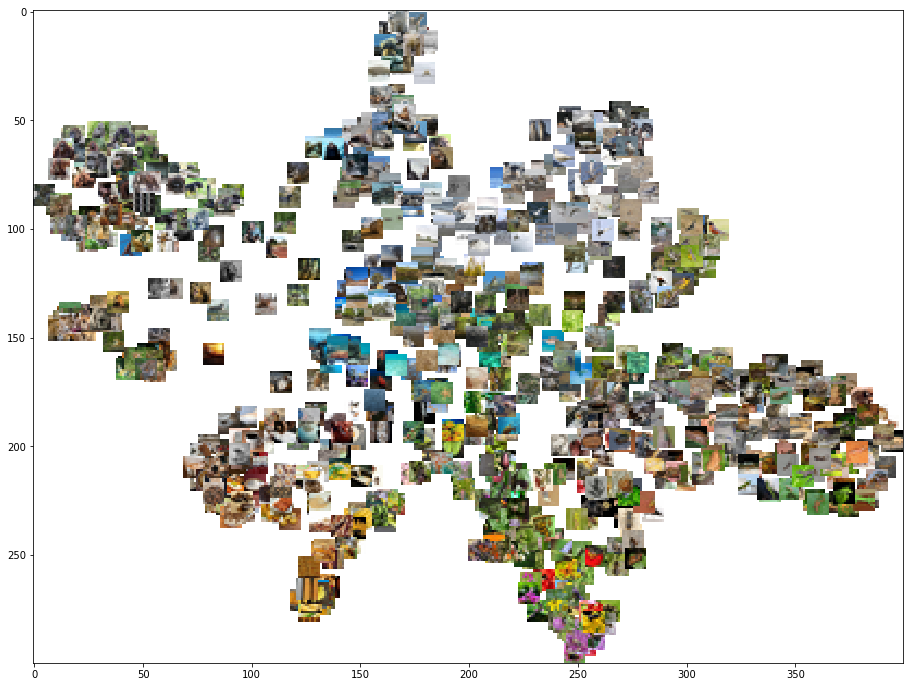

In [0]:
# 지현 씨가 돌린 코드 
from umap import UMAP
projection = UMAP(n_neighbors = 20, min_dist = 0.3, random_state=42, spread=0.5).fit_transform(X)

# # print(projection[:,0])
# x = projection[:,0]
# y =projection[:,1]

tx, ty = projection[:,0], projection[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

cols = []
def pltcolor(l):
    if l=='01':
        col='red'
    elif l=='02':
        col='green'
    elif l=='03':
        col='yellow'
    elif l=='04':
        col='magenta'
    else:
        col='blue'
    return col
# Create the colors list using the function above


for file, img, x, y in tqdm(zip(files,images, tx, ty)):
    category = file.split("_")
#     color= ['red' if g == category[0] else 'green' for g in group]
    col = pltcolor(category[0])
#     print(file+':'+category[0]+':'+col)
    cols.append(col)

plt.scatter(tx,ty, color=cols)
plt.show()

full_image = Image.new('RGBA', (width, height))

for img, x, y in tqdm(zip(images, tx, ty)):
    tile = Image.fromarray(img, 'RGB')
    rs = max(1, tile.width*10/max_dim, tile.height*10/max_dim)
    tile = tile.resize((int(tile.width*10/rs), int(tile.height*10/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)


98it [00:00, 133195.66it/s]


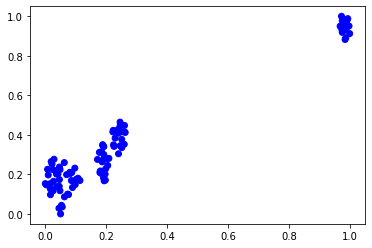

98it [00:00, 630.26it/s]


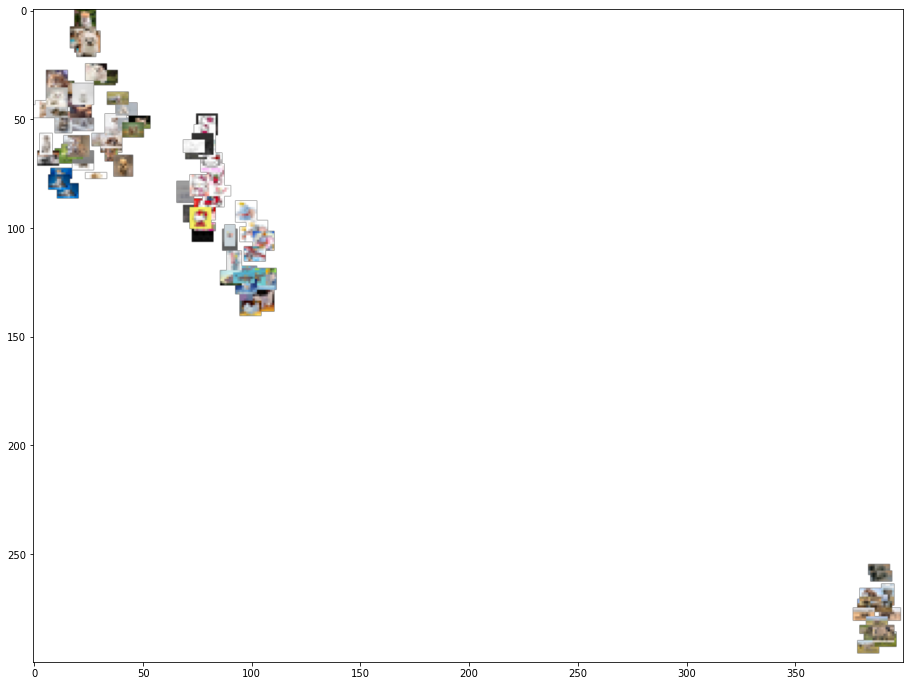

In [105]:
from umap import UMAP
projection = UMAP(n_neighbors = 20, min_dist = 0.3, random_state=42, spread=0.5).fit_transform(X)

# # print(projection[:,0])
# x = projection[:,0]
# y =projection[:,1]

tx, ty = projection[:,0], projection[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

cols = []
def pltcolor(l):
    if l=='01':
        col='red'
    elif l=='02':
        col='green'
    elif l=='03':
        col='yellow'
    elif l=='04':
        col='magenta'
    else:
        col='blue'
    return col
# Create the colors list using the function above


for file, img, x, y in tqdm(zip(files,images, tx, ty)):
    category = file.split("_")
#     color= ['red' if g == category[0] else 'green' for g in group]
    col = pltcolor(category[0])
#     print(file+':'+category[0]+':'+col)
    cols.append(col)

plt.scatter(tx,ty, color=cols)
plt.show()

full_image = Image.new('RGBA', (width, height))

for img, x, y in tqdm(zip(images, tx, ty)):
    tile = Image.fromarray(img, 'RGB')
    rs = max(1, tile.width*10/max_dim, tile.height*10/max_dim)
    tile = tile.resize((int(tile.width*10/rs), int(tile.height*10/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

# 추출된 특징으로 클러스터를 만들기.

### 방법
1. k-nearest neighbors 알고리즘으로 가장 가까운 이웃들을 보기.
